In [110]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.common.utils.text import build_vocab
from torchlake.sequence_data.models.lstm import LSTMDiscriminator
from torchlake.sequence_data.models.gru import GRUDiscriminator
from torchlake.sequence_data.models.base import RNNGenerator
from torchlake.sequence_data.models.seq2seq import Seq2Seq, GlobalAttention, LocalAttention, BahdanauAttention
from torchtext.data.utils import get_tokenizer
from torchlake.sequence_data.controller.trainer_seq2seq import Seq2SeqTrainer
from torchlake.common.controller.recorder import TrainRecorder
from torchtext.datasets import Multi30k
from tqdm import tqdm

To utilize this notebook, you have to install `spacy` and download `de_core_news_sm` and `en_core_web_sm` first

# setting

In [111]:
artifacts_path = Path("../../artifacts/seq2seq")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data/multi30k")

In [112]:
BATCH_SIZE = 128
CONTEXT = NlpContext(max_seq_len=32)

In [113]:
VAL_BATCH_SIZE = 32

In [114]:
DEVICE = torch.device(CONTEXT.device)

# data

In [115]:
SRC_LANGUAGE = 'de'
TRG_LANGUAGE = 'en'

In [116]:
tokenizers = {
    SRC_LANGUAGE: get_tokenizer('spacy', language=SRC_LANGUAGE), # de_core_news_sm
    TRG_LANGUAGE: get_tokenizer('spacy', language=TRG_LANGUAGE)  # en_web_core_sm
}

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(
d:\research\pytorch-implementations\.venv\Lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [117]:
train_iter, val_iter, test_iter = Multi30k(
    data_path.as_posix(),
    language_pair=(SRC_LANGUAGE, TRG_LANGUAGE),
)

In [118]:
for src, trg in train_iter:
    print(src)
    print(trg)
    break

Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
Two young, White males are outside near many bushes.


In [119]:
src_lengths, trg_lengths = [], []
for src, trg in train_iter:
    src_lengths.append(len(tokenizers[SRC_LANGUAGE](src)))
    trg_lengths.append(len(tokenizers[TRG_LANGUAGE](trg)))

(array([3.000e+00, 1.000e+00, 2.800e+01, 1.530e+02, 2.089e+03, 2.251e+03,
        6.085e+03, 3.232e+03, 5.429e+03, 2.165e+03, 3.103e+03, 1.147e+03,
        1.493e+03, 4.760e+02, 3.550e+02, 4.990e+02, 1.180e+02, 1.860e+02,
        4.900e+01, 6.400e+01, 1.700e+01, 2.800e+01, 5.000e+00, 1.500e+01,
        6.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00]),
 array([ 0.        ,  1.46666667,  2.93333333,  4.4       ,  5.86666667,
         7.33333333,  8.8       , 10.26666667, 11.73333333, 13.2       ,
        14.66666667, 16.13333333, 17.6       , 19.06666667, 20.53333333,
        22.        , 23.46666667, 24.93333333, 26.4       , 27.86666667,
        29.33333333, 30.8       , 32.26666667, 33.73333333, 35.2       ,
        36.66666667, 38.13333333, 39.6       , 41.06666667, 42.53333333,
        44.        ]),
 <BarContainer object of 30 artists>)

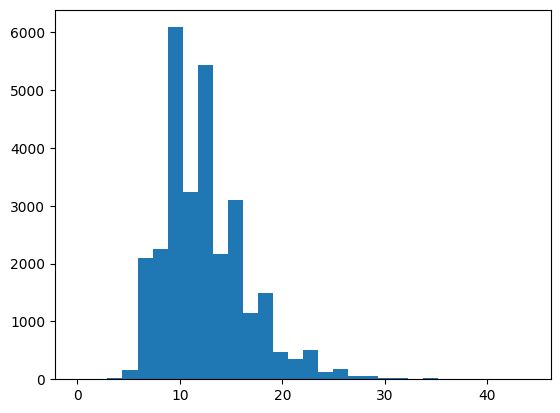

In [120]:
plt.hist(src_lengths, bins=30)

(array([1.000e+00, 0.000e+00, 8.000e+00, 3.200e+01, 2.110e+02, 2.477e+03,
        2.427e+03, 3.049e+03, 6.523e+03, 2.849e+03, 4.639e+03, 1.558e+03,
        1.326e+03, 1.774e+03, 5.860e+02, 4.450e+02, 5.080e+02, 1.720e+02,
        1.110e+02, 1.440e+02, 4.300e+01, 5.500e+01, 1.200e+01, 1.100e+01,
        1.700e+01, 1.000e+01, 3.000e+00, 5.000e+00, 2.000e+00, 3.000e+00]),
 array([ 0.        ,  1.36666667,  2.73333333,  4.1       ,  5.46666667,
         6.83333333,  8.2       ,  9.56666667, 10.93333333, 12.3       ,
        13.66666667, 15.03333333, 16.4       , 17.76666667, 19.13333333,
        20.5       , 21.86666667, 23.23333333, 24.6       , 25.96666667,
        27.33333333, 28.7       , 30.06666667, 31.43333333, 32.8       ,
        34.16666667, 35.53333333, 36.9       , 38.26666667, 39.63333333,
        41.        ]),
 <BarContainer object of 30 artists>)

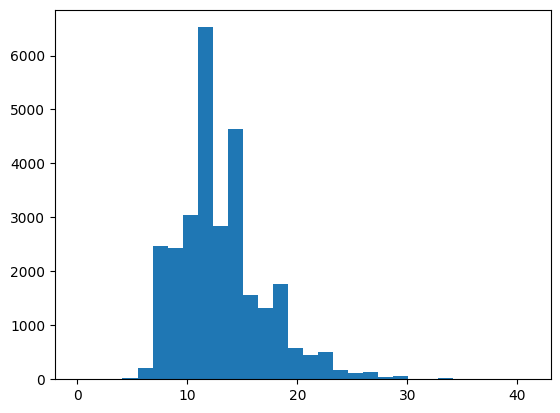

In [121]:
plt.hist(trg_lengths, bins=30)

In [122]:
# from torchtext.vocab.vectors import Vectors
# vector = Vectors("../../artifacts/glove/glove.6B.300d.txt")

In [123]:
# vocab = build_vocab(
#     map(lambda x: [x], vector.stoi.keys()),
#     context=NlpContext(min_frequency=0, min_seq_len=1),
# )

In [124]:
vocabs = {
    SRC_LANGUAGE: build_vocab(map(lambda x: tokenizers[SRC_LANGUAGE](x[0]), train_iter), CONTEXT),
    # SRC_LANGUAGE: vocab,
    TRG_LANGUAGE: build_vocab(map(lambda x: tokenizers[SRC_LANGUAGE](x[1]), train_iter), CONTEXT),
}

In [125]:
vocab_sizes = {
    SRC_LANGUAGE: len(vocabs[SRC_LANGUAGE]),
    TRG_LANGUAGE: len(vocabs[TRG_LANGUAGE]),
}

In [126]:
vocab_sizes

{'de': 3630, 'en': 3365}

In [127]:
src_transform = T.Sequential(
    T.VocabTransform(vocabs[SRC_LANGUAGE]),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

trg_transform = T.Sequential(
    T.VocabTransform(vocabs[TRG_LANGUAGE]),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [128]:
def datapipe_factory(datapipe):
    return (
        datapipe.map(lambda pair: (pair[0].rstrip("\n"), pair[1].rstrip("\n")))
        # 1409.3215 p.2: reverse source sentence
        # don't use
        # .map(lambda pair: (pair[0][::-1], pair[1]))
        .map(
            lambda pair: (
                tokenizers[SRC_LANGUAGE](pair[0]),
                tokenizers[TRG_LANGUAGE](pair[1]),
            )
        )
    )

In [129]:
train_datapipe, val_datapipe = datapipe_factory(train_iter), datapipe_factory(val_iter)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [130]:
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_transform(src_sample))
        tgt_batch.append(trg_transform(trg_sample))

    return torch.stack(src_batch), torch.stack(tgt_batch)

In [131]:
NUM_WORKERS = get_num_workers()

In [132]:
train_loader = DataLoader(
    train_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

test_loader = DataLoader(
    val_datapipe,
    batch_size=VAL_BATCH_SIZE,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

In [133]:
for src, trg in train_loader:
    print(src.shape, trg.shape)
    break

torch.Size([128, 32]) torch.Size([128, 32])


# Model

In [134]:
NUM_LAYERS = 4
EMBED_DIM = 512
HIDDEN_DIM = 256
BIDIRECTIONAL = True
FACTOR = 2 if BIDIRECTIONAL else 1

In [135]:
encoder = LSTMDiscriminator(
    vocab_sizes[SRC_LANGUAGE],
    EMBED_DIM,
    HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    drop_fc=True,
    context=CONTEXT,
)

In [136]:
# encoder.foot.weight.data.copy_(torch.cat([torch.rand(4, EMBED_DIM), vector.vectors],0 ))
# encoder.foot.weight.data[4:, :].requires_grad_(False)

In [137]:
# attention = None

# attention = BahdanauAttention(
#     HIDDEN_DIM * FACTOR,
#     HIDDEN_DIM,
#     decoder_bidirectional=BIDIRECTIONAL,
# )

# attention = GlobalAttention(
#     HIDDEN_DIM * FACTOR,
#     HIDDEN_DIM,
#     decoder_bidirectional=BIDIRECTIONAL,
# )

CONTEXT_SIZE = 2
attention = LocalAttention(
    HIDDEN_DIM * FACTOR,
    HIDDEN_DIM,
    decoder_bidirectional=BIDIRECTIONAL,
    context_size=CONTEXT_SIZE,
)

In [138]:
decoder = RNNGenerator(
    LSTMDiscriminator(
        vocab_sizes[TRG_LANGUAGE],
        EMBED_DIM,
        HIDDEN_DIM,
        context_dim=HIDDEN_DIM * FACTOR if attention is not None else 0,
        output_size=vocab_sizes[TRG_LANGUAGE],
        num_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        context=CONTEXT,
    ),
    attention=attention,
)

In [139]:
model = Seq2Seq(encoder, decoder, context=CONTEXT).to(DEVICE)

In [140]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Seq2Seq                                  --
├─LSTMDiscriminator: 1-1                 --
│    └─Embedding: 2-1                    1,858,560
│    └─LSTM: 2-2                         6,307,840
│    └─LayerNorm: 2-3                    1,024
│    └─Identity: 2-4                     --
├─RNNGenerator: 1-2                      --
│    └─LocalAttention: 2-5               --
│    │    └─Linear: 3-1                  262,656
│    │    └─Linear: 3-2                  513
│    │    └─Linear: 3-3                  262,656
│    └─LSTMDiscriminator: 2-6            --
│    │    └─Embedding: 3-4               1,722,880
│    │    └─LSTM: 3-5                    7,356,416
│    │    └─LayerNorm: 3-6               1,024
│    │    └─Linear: 3-7                  1,726,245
Total params: 19,499,814
Trainable params: 19,499,814
Non-trainable params: 0

# Training

In [141]:
EPOCH = 30

In [142]:
trainer = Seq2SeqTrainer(EPOCH, DEVICE, feature_last=True)
trainer.set_curriculum_strategy("inverse_sigmoid", k=5)

In [143]:
criterion = nn.CrossEntropyLoss(
    ignore_index=CONTEXT.padding_idx,
    reduction="sum",
)
optimizer = torch.optim.Adadelta(model.parameters(), lr=1e-1)

In [144]:
recorder = TrainRecorder(total_epoch=EPOCH)
recorder.calc_dataset_size(map(lambda x: x[0], train_loader))

227it [00:06, 34.23it/s]


29001

In [145]:
# to continue
# recorder.total_epoch = EPOCH

In [146]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    "min",
    patience=2,
    threshold=0.05,
    threshold_mode="rel",
)

In [147]:
# scaler = torch.amp.grad_scaler.GradScaler()

In [148]:
training_loss = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler,
    # scaler=scaler,
    recorder=recorder,
)

Enable AMP: False
Training...


227it [00:54,  4.17it/s]


Epoch 1 : 66.26662653133191 (0%)


227it [00:53,  4.21it/s]


Epoch 2 : 54.63157326808237 (-18%)


227it [00:52,  4.32it/s]


Epoch 3 : 49.782295281506975 (-9%)


227it [00:53,  4.24it/s]


Epoch 4 : 47.15003924298945 (-5%)


227it [00:52,  4.32it/s]


Epoch 5 : 44.808047685182224 (-5%)


227it [00:52,  4.36it/s]


Epoch 6 : 42.50169357037256 (-5%)


227it [00:51,  4.37it/s]


Epoch 7 : 41.2345866710415 (-3%)


227it [00:52,  4.32it/s]


Epoch 8 : 40.0508455493722 (-3%)


227it [00:55,  4.08it/s]


Epoch 9 : 38.578334372831414 (-4%)


227it [00:52,  4.28it/s]


Epoch 10 : 37.40897697358496 (-3%)


227it [01:00,  3.77it/s]


Epoch 11 : 36.173979352274486 (-3%)


227it [00:51,  4.40it/s]


Epoch 12 : 34.7577931377905 (-4%)


227it [00:50,  4.48it/s]


Epoch 13 : 33.41608024426957 (-4%)


227it [00:50,  4.52it/s]


Epoch 14 : 32.15495677277292 (-4%)


227it [00:51,  4.43it/s]


Epoch 15 : 30.930379269653418 (-4%)


227it [00:52,  4.33it/s]


Epoch 16 : 29.694658932827743 (-4%)


227it [00:50,  4.50it/s]


Epoch 17 : 28.55539779844609 (-4%)


227it [00:50,  4.51it/s]


Epoch 18 : 27.401603305435618 (-4%)


227it [00:51,  4.44it/s]


Epoch 19 : 26.269032323743946 (-4%)


227it [00:50,  4.47it/s]


Epoch 20 : 25.141374624777214 (-4%)


227it [00:50,  4.49it/s]


Epoch 21 : 24.02271488129584 (-4%)


227it [00:51,  4.44it/s]


Epoch 22 : 22.95011139836773 (-4%)


227it [00:52,  4.36it/s]


Epoch 23 : 21.848549378213782 (-5%)


227it [00:52,  4.35it/s]


Epoch 24 : 20.73871651246941 (-5%)


227it [00:52,  4.32it/s]


Epoch 25 : 19.7008150926167 (-5%)


227it [00:52,  4.32it/s]


Epoch 26 : 18.709967625880612 (-5%)


227it [00:52,  4.34it/s]


Epoch 27 : 17.702549904495484 (-5%)


227it [00:53,  4.21it/s]


Epoch 28 : 16.71284915198909 (-6%)


227it [00:52,  4.29it/s]


Epoch 29 : 15.782287183052425 (-6%)


227it [00:54,  4.19it/s]

Epoch 30 : 14.864955731759515 (-6%)


In [149]:
# plain, 4, bi
if model.head.neck is None:
    plt.plot(training_loss)

In [150]:
# Bahdanau, 4, bi
if model.head.neck is not None and isinstance(model.head.neck, BahdanauAttention):
    plt.plot(training_loss)

In [151]:
# global, 4, bi
if model.head.neck is not None and isinstance(model.head.neck, GlobalAttention):
    plt.plot(training_loss)

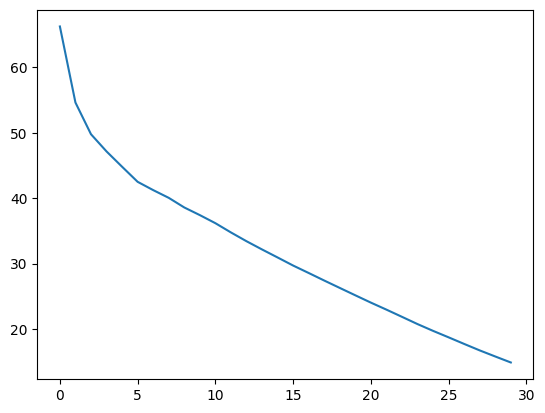

In [152]:
# local, 4, bi
if model.head.neck is not None and isinstance(model.head.neck, LocalAttention):
    plt.plot(training_loss)

# Save

In [153]:
from torchlake.common.controller.weight_manager import WeightManager

In [154]:
manager = WeightManager(artifacts_path.joinpath("seq2seq.{attention}.{bidirectional}.{num_layer}.pth").as_posix())

In [155]:
attention_name = "plain"
if model.head.neck is not None:
    if isinstance(model.head.neck, GlobalAttention):
        attention_name = "global"
    elif isinstance(model.head.neck, LocalAttention):
        attention_name = "local"
    elif isinstance(model.head.neck, BahdanauAttention):
        attention_name = "bahdanau"


model_path = manager.get_filename(
    attention=attention_name,
    bidirectional="bi" if model.head.head.factor == 2 else "uni",
    num_layer=model.head.head.num_layers,
)
model_path

WindowsPath('../../artifacts/seq2seq/seq2seq.local.bi.4.pth')

In [156]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\seq2seq\seq2seq.local.bi.4.pth, model size is 74.4MiB


In [157]:
manager.load_weight(model_path, model)

# Evaluate

## bleu

In [158]:
from torchmetrics.text import BLEUScore

In [159]:
metric = BLEUScore()

In [160]:
model.eval()
with torch.no_grad():
    for source_sentence, target_sentence in tqdm(test_loader):
        text = source_sentence.to(DEVICE)
        label = target_sentence.to(DEVICE)

        output = model.predict(text, topk=1)
        
        preds = []
        for o in output.tolist():
            translated = vocabs[TRG_LANGUAGE].lookup_tokens(o)
            try:
                start_idx, end_idx = translated.index(CONTEXT.bos_str), translated.index(CONTEXT.eos_str)
            except:
                start_idx, end_idx = 0, -1
            preds.append(" ".join(translated[start_idx+1 : end_idx]))
            
        labels = []
        for l in label.tolist():
            translated = vocabs[TRG_LANGUAGE].lookup_tokens(l)
            start_idx, end_idx = translated.index(CONTEXT.bos_str), translated.index(CONTEXT.eos_str)
            labels.append([" ".join(translated[start_idx+1 : end_idx])])
        
        metric.update(preds, labels)

32it [00:07,  4.51it/s]


In [ ]:
# plain, 4, bi: 0.2126
# badanau, 4, bi: 0.22
# global, 4, bi: 0.2062
# local, 4, bi: 0.2145
metric.compute()

tensor(0.2145)

## predict

In [163]:
model.eval()
with torch.no_grad():
    for source_sentence, target_sentence in tqdm(test_loader):
        text = source_sentence.to(DEVICE)
        label = target_sentence.to(DEVICE)

        output = model.predict(text, topk=1)
        
        preds = []
        for o in output.tolist():
            translated = vocabs[TRG_LANGUAGE].lookup_tokens(o)
            start_idx, end_idx = translated.index(CONTEXT.bos_str), translated.index(CONTEXT.eos_str)
            preds.append(" ".join(translated[start_idx+1 : end_idx]))

        texts = []
        for t in text.tolist():
            translated = vocabs[SRC_LANGUAGE].lookup_tokens(t)
            start_idx, end_idx = translated.index(CONTEXT.bos_str), translated.index(CONTEXT.eos_str)
            texts.append(" ".join(translated[start_idx+1 : end_idx]))

            
        labels = []
        for l in label.tolist():
            translated = vocabs[TRG_LANGUAGE].lookup_tokens(l)
            start_idx, end_idx = translated.index(CONTEXT.bos_str), translated.index(CONTEXT.eos_str)
            labels.append(" ".join(translated[start_idx+1 : end_idx]))
        
        for text, label, pred in zip(texts, labels, preds):
            print("text:", text)
            print("label:", label)
            print("pred:", pred)
            print("--------------------------")
            
        break

0it [00:00, ?it/s]

text: Zwei Männer beobachten einen anderen , während dieser am nassen Zement <unk> Hand <unk> .
label: Two men are observing another as he puts the finishing touches on wet cement .
pred: Two men look as another another looks out on a bucket of water behind their <unk> .
--------------------------
text: Ein Mädchen mit einem weißen Trikot , schwarzen Shorts und einem Stirnband spielt Volleyball .
label: A girl wearing a white shirt , black shorts , and a headband is playing volleyball .
pred: Young girl with white hair , white shorts , and a skirt is playing tennis .
--------------------------
text: <unk> <unk> auf Grün , während die Menschen sich Motorräder ansehen .
label: Green traffic <unk> light up as people look at motorcycles .
pred: <unk> on the <unk> of people to people on the street .
--------------------------
text: Ein Mann mit einem großen Hut im <unk> .
label: A man with a large hat in the bushes .
pred: A man with a large hat in in his <unk> .
--------------------------


# debug

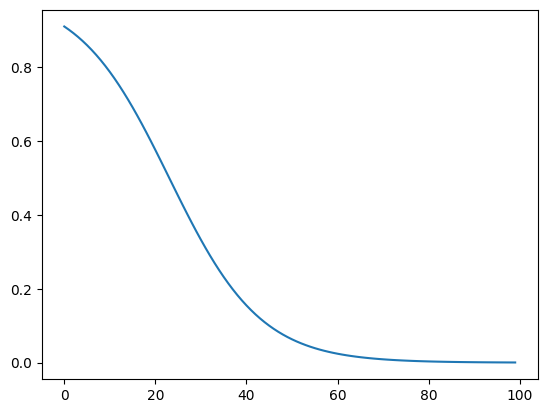

In [44]:
trainer = Seq2SeqTrainer(EPOCH, DEVICE, feature_last=True)
trainer.set_curriculum_strategy("inverse_sigmoid", k=10)

ratios = []
for t in range(100):
    trainer.recorder.current_epoch = t
    ratios.append(trainer.teacher_forcing_raio)

plt.plot(ratios)